# Run the mesh

Load the mesh

In [ ]:
import openmesh as om
import matplotlib.pyplot as plt

# mesh = om.read_trimesh('dm.off')
mesh = om.read_trimesh('dm4.off')
P = mesh.points()

---

Iterate over faces in order to calculate barycenters.
This is done by generate a local list of local vertex coordinates and then average over them.

In [2]:
import numpy as np

# option to generalize to calculate any barycenter values, given the node value
# def getbar(x,y):
# applies for s -> sbar, which is needed for both equations, for $\phi$ and for $s$
# sbar = getbar(s);

def getbar(x):
    xbar = []
    # ybar = []

    for fh in mesh.faces():
        ## nCell = fh.idx()
        xloc = []
        # yloc = []
        for vh in mesh.fv(fh):
            # print(vh.idx())
            xloc.append(x[vh.idx()])
            # yloc.append(y[vh.idx()])
    
        xbar.append(sum(xloc)/3)
        # ybar.append(sum(yloc)/3)

    # transform the list of points into an array
    xbar = np.array(xbar)
    # ybar = np.array(ybar)    
    return xbar # , ybar

# without parameters
def old_getbar(): 
    xbar = []
    ybar = []

    for fh in mesh.faces():
        nCell = fh.idx()

        xloc = []
        yloc = []
        for vh in mesh.fv(fh):
            # print(vh.idx())
            # xloc.append(x[vh.idx()])
            # yloc.append(y[vh.idx()])
    
            p = mesh.point(vh)
            xloc.append(p[0])
            yloc.append(p[1])
    
        xbar.append(sum(xloc)/3)
        ybar.append(sum(yloc)/3)

    # transform the list of points into an array
    xbar = np.array(xbar)
    ybar = np.array(ybar)    
    return xbar, ybar

# initialization
XX = P[:,0]
YY = P[:,1]
TT = XX*(1+0.5*(1-YY)**2)
SS = XX*(1-YY) 
    # z = xbar**0.5 + (1-ybar)**3
    # z = x*(1+0.5*(1-y)**2)
    
WW = 1/(XX**2+(1-YY)+1e-3)**0.25     
Tref = TT.copy()
Sref = SS.copy()

XXbar, YYbar = old_getbar()
# XXbar = getbar(XX)
# YYbar = getbar(YY)


## Boundary treatment

Regarding the handling of boundary and interior points
there are different issues that need to be dealt with in different instances.

1. Marking the active nodes: Done in routine "marker=mark_active(x,y)"
     * the non-active nodes are registered as a boundary point, where the value according to the boundary condition applies
2. Assigning the active values for the optimization: Done in routine "U=get_active(marker,T,S)
3. Assigning boundary condition: Done when defining initial condition
    * The initial guess should at the boundary should be consistent with the boundary condition.   


In [3]:
# this routine is to sincronize the masking of boundary values
# with the assignation of active variables
# with the goal that nothing gets missed

# marks active nodes in the interior of the domain
def mark_active(x,y):
    marker=np.zeros(len(mesh.vertices()))
    k=0
    for vh in mesh.vertices():
        if(x[k] == 0):
            marker[k]=0
        elif(y[k] == 1):
            marker[k]=0
        else:
            marker[k]=1
        k+=1
    return marker

MARKER=mark_active(XX,YY)


In [4]:
# obtain the active values
# now operating with the information of the marked nodes
def get_active(marker,T,S):
    j=0
    k=0;
    u1 = []
    u2 = []
    for vh in mesh.vertices():
        if(marker[k] == 1):
            # this is a design choice: how to set the U values
            u1.append(T[k])
            u2.append(S[k])
        k+=1
    uu = [*u1, *u2]
    uu = np.array(uu)
    return uu

UU=get_active(MARKER,TT,SS)

## Calculate gradient $\nabla \phi$
Calculate gradient from values on the triangle, namely from the given values of $\phi$ in the vertices

There is no FV interpretation, but the active positions are the vertices. 
Yet it is iterated over the faces, as any equations correspond to a face.

If we have a model of form
\begin{align*}
    f(x,y) = ax + by + c
\end{align*}
then the gradient is calculated as
\begin{align*}
    \nabla f(x,y) = (a, b)
\end{align*}



In [6]:
# file = open('gradient_file', 'w')

# sx=[]; sy=[]
# calculate gradients
def getgrad(x,y,t):
    # ? just in any case declare global variables
    m=np.zeros((3, 3))
    b=np.zeros((3, 1))
    gx=[]
    gy=[]
    # iterate over all faces
    for fh in mesh.faces():
        # iterate over the face's vertices
        j=0
        for vh in mesh.fv(fh):
            k=vh.idx()
            # print('    v', vh.idx(),': (', X[k],',', Y[k],')')
            m[j,0]=x[k]
            m[j,1]=y[k]
            m[j,2]=1
            b[j]=t[k] # value at vertex
            j=j+1
        g = np.linalg.solve(m, b)        
        # print('\n\n M=',M,'\n\n B=', B, '\n\n g=', g, '\n\n')
        gx.append(float(g[0]))
        gy.append(float(g[1]))
        ## T=j+':'+x[0]+','+x[1]+'\n'
        ## print(T)
        # print('g(', j, ') =', x[0], x[1], '\n')
        # file.write('...')
        # print('>>>', j, ':', x[0], x[1], '\n')
        #
        # file.close()  # you can omit in most cases as the destructor will call it
        
    gx = np.array(gx)
    gy = np.array(gy)
    
    return gx, gy

GX, GY = getgrad(XX,YY,TT)
# print(type(gx))

SX=GX/((GX**2+GY**2)**0.5)
SY=GY/((GX**2+GY**2)**0.5)

# quick validation

print(len(SX),len(SY),len(mesh.faces()))
print(len(SS),len(TT),len(XX),len(YY),len(mesh.vertices()))
# print(len(R))


760 760 760
420 420 420 420 420


## Calculation of gradient $\nabla s$

* $\phi$ and $\nabla \phi$ are given
* a boundary condition is given, at $x=0$ and at $y=1$

The value of $\nabla s$ is given by the normalization of $\nabla \phi$

\begin{align*}
    \nabla s = \frac{\nabla \phi}{\| \nabla \phi \|}
\end{align*}


On a local scale, in terms of an explicit construction we have
* Given $s_1, s_2, \nabla s$
* find $s_3$, 


i.e. there are two equations given for fitting c
\begin{align*}
    s_1 = a x_1 + b y_1 + c \\
    s_2 = a x_2 + b y_2 + c
\end{align*}
such that then $s_3$ can be found explicitely as
\begin{align*}
    s_3 = a x_3 + b y_3 + c
\end{align*}

However, in an inmplicit consideration,
$c$ is an unknown corresponding to the $s$ value in the face center.
\begin{align*}
    c = \frac{1}{3} (s_1 + s_2 + s_3)
\end{align*}
The equations have the form
\begin{align*}
    s_k - (s_1+s_2+s_3)/3 = a x_k + b y_k, \qquad k=1,2,3
\end{align*}

* one vertex appears in several faces, thus there is an overdetermined system
* for the boundary treatment: some variables are given by the boundary condition, some remain free:



                

---

# Coupled equations for $\phi$ and $s$:

There are different strategies to solve the coupled model equations:
* Collect all equations in a single one, and solve everything coupled with linearization.
* Do a 2-step iteration, where in one step the equation for $\phi$ is solved, and in another step the equation for $s$.

---

* not so clear difference between local and global variables, how the variables should be

* U contains first $\phi$ values, and then the $s$ values [?]
* only phi variales are stored, since the s variables are a consequence that do not need an own representation in the algoritm
* both $\phi$ and $s$ are needed as variables, in order to have a reference instance for iteration

---

# Equations for $\phi$:

For all faces
* calculate gradient
* define function: print into file or append it to residual
\begin{align*}
    F = \| \nabla \phi \| - v
\end{align*}

### ¿The variable is named $\phi$ or $t$ or $u$?

---

# Equations for $s$:

    for all faces
        for all vertices, $v \in V$
            if v is not on boundary # otherwise no equation is needed
                G[k] = a_f^s x_v + b_f^s y_v - z_v            
                for all vertices, $w \in W$
                    G[k]-= z_w / 3

---

each face gives three equations
* get the three indices, i.e. the algorithm works for any other mesh representation, and does not depend too much on the data structure of openmesh

This system is actually non-linear as $a^s, b^s$ depend on $\phi$.

### ? how to distinguish non-active variables at the boundaries


In [7]:
import math

# 
# heterogenity
def a(x,y):
    return a1(x,y)

def a1(x,y):
    if y <= 0.5:
        het=1
    elif y <= 0.6:
        het=2
    elif y <= 0.7:
        het=1
    else:
        het=0.5
    return het

def velocity(x,y,s):
    return a(x,y)*y/(s+0.001)


# maps U to (t,s)
# it is used in the residual routine to map U to the working variables 
# but it is also used to get the T, S values for the visualization
def u2ts(u):
    # assign variables, first to $\phi$, then to $s$
    NU=int(len(u)/2)
        
    N=len(mesh.vertices())
    s=np.zeros(N)
    t=np.zeros(N)
    
    j=0
    k=0    
    for vh in mesh.vertices():
        # print('M[', j,']=', MARKER[j])
        if(MARKER[j] == 1): # global !
            # print('\t u[',k,']=', u[k])
            t[j]=u[k]
            s[j]=u[NU+k]
            k=k+1
        else:
            t[j]=TT[j]
            s[j]=SS[j]
            # boundary...
        j=j+1
        
        # print('j \n', j ) 
        # print("DEBUG:", N, len(t), 'len(u)', len(u), '#vert', len(mesh.vertices()))
        # print(' \n TT:', TT, ' \n SS:', SS, '\n uu', u)
        # print(' \n t:', t, ' \n s:', s)        
    return t, s


###################################################
# minuscula refer to local variables [?]
# need to use global variables in this instance, in order to optimizae over u
def residual(u):
    t,s = u2ts(u)
    
    ###################################################
    # calculate gradients, that are needed for equations for $s$
    gx, gy = getgrad(XX,YY,t) # t needs to be local [!]
    
    # print(type(gx))
    sx=gx/((gx**2+gy**2)**0.5)
    sy=gy/((gx**2+gy**2)**0.5)
            
    # calculate values at barycenters, that are needed for equations for $\phi$
    # Xbar, Ybar = old_getbar() # posiciones fijas [!]
    
    Xbar = getbar(XX) # variable status [to define here or before?]
    Ybar = getbar(YY)
    sbar = getbar(s) # from local to local
        
    ###################################################
    # start calculating residuals

    rr = []
    ###################################################
    # equations for s
    for fh in mesh.faces():
        j = fh.idx()
        K = []
        for vh in mesh.fv(fh):   
            k = vh.idx()
            K.append(k)
            rr.append(sx[j]*XX[k] + sy[j]*YY[k] + sbar[j] - s[k])
            # ^^^ <--- this, together with the sbar[j] definition might replace all the rest 
            
        # sbar[j] = (s[k0]+s[k1]+s[k2])/3; # for use in this and the other equation
                                           # this should be calulated outside the equations            
            
        # option: get index set K directly from simplex of triangulation
        # the the iteration is over the mesh geometry as given in the mpl, and there is no need to use om
        # print(K)
        # k0 = K[0]
        # k1 = K[1]
        # k2 = K[2]
        # r0 = sx[j]*X[k0] + sy[j]*Y[k0] + sbar[j] - s[k0]
        # r1 = sx[j]*X[k1] + sy[j]*Y[k1] + sbar[j] - s[k1]
        # r2 = sx[j]*X[k2] + sy[j]*Y[k2] + sbar[j] - s[k2]

        # rr.append(r0)
        # rr.append(r1)
        # rr.append(r2)
    
    ###################################################
    # equations for phi
    for fh in mesh.faces():
        j=fh.idx()
        # here Xbar, Ybar enters as a variable 
        r=math.sqrt(gx[j]**2+gy[j]**2) - velocity(Xbar[j], Ybar[j], sbar[j]) # sbar with local dependence
        # print(':', r)
        # r=k;
        rr.append(r)
        
    rr = np.array(rr)
    return rr

MARKER = mark_active(XX,YY)
UU = get_active(MARKER,TT,SS)
RR = residual(UU)

print('UU: ', UU)
print('RR:', RR)
print('TT:', TT)
print('MARKER:', MARKER)


UU:  [0.375      0.75       1.125      1.5        1.875      2.25
 2.625      3.         3.375      3.75       4.125      4.5
 4.875      5.25       5.625      6.         6.375      6.75
 7.125      0.3628125  0.725625   1.0884375  1.45125    1.8140625
 2.176875   2.5396875  2.9025     3.2653125  3.628125   3.9909375
 4.35375    4.7165625  5.079375   5.4421875  5.805      6.1678125
 6.530625   6.8934375  0.35125    0.7025     1.05375    1.405
 1.75625    2.1075     2.45875    2.81       3.16125    3.5125
 3.86375    4.215      4.56625    4.9175     5.26874999 5.61999999
 5.97124999 6.32249999 6.67374999 0.3403125  0.680625   1.0209375
 1.36124999 1.70156249 2.04187499 2.38218749 2.72249999 3.06281249
 3.40312499 3.74343749 4.08374998 4.42406248 4.76437498 5.10468748
 5.44499998 5.78531248 6.12562498 6.46593748 0.33       0.66
 0.99       1.32       1.65       1.98       2.31       2.64
 2.96999999 3.29999999 3.62999999 3.95999999 4.28999999 4.61999999
 4.94999999 5.27999999 5.60999999 

## Equation generator
Assemble equation corresponding to the face: 
There is one non-linear equation for a face. The equations are expressed in terms of residuals.

---

In the definition
\begin{align*}
    z = x(1+0.5*(1-y)^2)
\end{align*}
mainly it is assured that the boundary condition
\begin{align*}
    z(x=0)=0, \qquad z(y=1)=x
\end{align*}
keeps holding.

---

Algorithm for $F(\phi)$, in the non-linear system of equations
for form $F = 0$; nested iteration

In [9]:
# initial guess that satisfies the initial condition (such that the calculation can be done in one line)

def cost(u):
    R=residual(u)
    # print(R)
    c=np.inner(R,R)
    return c

# MARKER=mark_active(x,y)

UU=get_active(MARKER,TT,SS)
R = residual(UU)
print(type(residual), type(R), type(UU))
print(len(mesh.faces()))
print(len(mesh.vertices()))
print(len(R))
print('UU =', UU)
print('cost =', cost(UU))



<class 'function'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
760
420
3040
UU = [0.375      0.75       1.125      1.5        1.875      2.25
 2.625      3.         3.375      3.75       4.125      4.5
 4.875      5.25       5.625      6.         6.375      6.75
 7.125      0.3628125  0.725625   1.0884375  1.45125    1.8140625
 2.176875   2.5396875  2.9025     3.2653125  3.628125   3.9909375
 4.35375    4.7165625  5.079375   5.4421875  5.805      6.1678125
 6.530625   6.8934375  0.35125    0.7025     1.05375    1.405
 1.75625    2.1075     2.45875    2.81       3.16125    3.5125
 3.86375    4.215      4.56625    4.9175     5.26874999 5.61999999
 5.97124999 6.32249999 6.67374999 0.3403125  0.680625   1.0209375
 1.36124999 1.70156249 2.04187499 2.38218749 2.72249999 3.06281249
 3.40312499 3.74343749 4.08374998 4.42406248 4.76437498 5.10468748
 5.44499998 5.78531248 6.12562498 6.46593748 0.33       0.66
 0.99       1.32       1.65       1.98       2.31       2.64
 2.96999999 3.2999999

# Optimization - Minimization

In [ ]:
import scipy.optimize as opt
import time
import sys
# sys.stdout = open('methods-performance.txt', 'w') # screen output into file 
# for k in range(1, 77, 1):
# for k in range(1, 2, 1):
# for method in ['tnc', 'slsqp', 'nelder-mead', 'powell', 'cg', 'bfgs', 'l-bfgs-b','cobyla']:
# for method in ('nelder-mead', 'powell', 'cobyla','L-BFGS-B','BFGS'):
if False: 
    U = get_active(MARKER,TT,SS)
    t0 = time.time()
    res = opt.minimize(cost, U, method=method, tol=1e-10, options={'maxiter': 2, 'disp': True})
    
    #
    # res = opt.minimize(cost, U, method='L-BFGS-B', tol=1e-10, options = {'maxiter': 200}) # [worked !]     
    # res = opt.minimize(cost, U, method='BFGS', tol=1e-10, options = {'maxiter': 2}) # [worked !] 
    # res = opt.minimize(cost, U, method='cg', tol=1e-10, options = {'maxiter': 2}) # [worked !]     
    # res = opt.minimize(cost, U0, method='cobyla', tol=1e-10, options = {'maxiter': 10000}) # [worked !]
    # res = opt.minimize(cost, U, method='Powell', tol=1e-10, options = {'maxiter': 20}) # [worked !] 
    t1 = time.time()
    
    # U = res.x
    print(res)
    print('\n<<< ---------',k,'----  %s' % method, ' ------ dt = %.1f \n\n\n' % float(t1 - t0))

In [ ]:
#
import scipy.optimize as opt
import time
U = get_active(MARKER,TT,SS)
t0 = time.time()
res = opt.minimize(cost, U, method='cg', tol=1e-10, options = {'maxiter': 20}) # [worked !] 
t1 = time.time()
print('%.2f' % float((t1 - t0)/60))

U=res.x
# print(U)

In [ ]:
import sys

o = open('res.txt','w')
print(res.x, file=o)
# o.close()


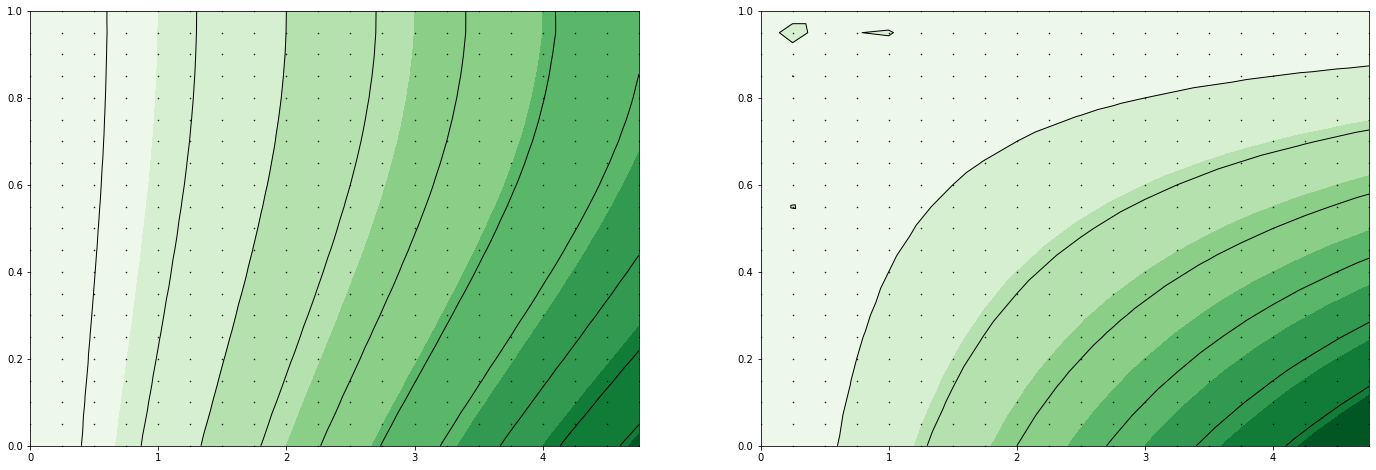

In [27]:
import numpy as np

TT, SS = u2ts(U)
cmap = plt.get_cmap('Greens')
levels = np.linspace(-5, 9, 21)

fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(24, 8))
plt1.plot(XX, YY, '.k', markersize=1)
plt1.tricontourf(XX, YY, TT, cmap=cmap)
plt1.tricontour(XX, YY, TT, colors='k',linewidths=1, levels=levels)
# plt1.savefig('T')

plt2.plot(XX, YY, '.k', markersize=1)
plt2.tricontourf(XX, YY, SS, cmap=cmap)
plt2.tricontour(XX, YY, SS, colors='k',linewidths=1, levels=levels)

In [23]:
plt1.xlabel('x')
plt1.ylabel('y')
plt1.xticks(fontsize=12)
plt1.yticks(fontsize=12)
plt1.savefig('T')

AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

## [Algorithms for overdetermined systems are not working]


In [ ]:
from scipy import optimize
from scipy.optimize import fsolve, newton_krylov

U=get_active(MARKER,TT,SS)
##################################################
# ...does not work
#
# res = optimize.broyden1(residual, U)
# res =  fsolve(residual, U)
# res = newton_krylov(residual, U, method='lgmres', verbose=1)
# print('Residual: %g' % abs(residual(res)).max())

# Gradient calculation

In [ ]:
def myJacobian(U):
    # g=np.zeros(len(U))
    h=1e-5
    for k in range(0, len(U)):
        print(k)
        Uplus=U.copy()
        Uplus[k]+=h
        Uminus=d.copy()
        Uminus[k]-=h
        # Some function "f" should be called
        # 
        # here there should be some matrix operation
        # sort of vstack
        # g[k]=(Uplus-Uminus)/(2*h)
    'not yet finished'
    g
    return g

def mygrad(U):
    g=np.zeros(len(U))
    h=1e-1
    h=10.0
    h=1.0
    for k in range(0, len(U)):
        # print(k)
        Uplus=U.copy()
        Uplus[k]+=h
        Uminus=U.copy()
        Uminus[k]-=h
        cplus=cost(Uplus)
        cminus=cost(Uminus)
                
        # print(Uplus[k]-Uminus[k])
        # print(cost(Uplus),cplus)
        dc=(cplus-cminus)/(2.0*h)
        # print(dc)
        g[k]=dc
    return g

U=get_active(MARKER,TT,SS)
g=mygrad(U)
print(g)

# Post-processing

In [ ]:
# fun: 69.47973587671711
# message: 'Optimization terminated successfully.'
U = np.array([ 4.80546216e+00,  4.87701355e+00,  4.89544713e+00,  4.92715133e+00,
        2.79189021e+00,  4.56831846e+00,  4.72529841e+00,  4.76092619e+00,
        2.09021912e+00,  3.24228845e+00,  3.97753313e+00,  4.16152826e+00,
        1.74669513e+00,  2.71142002e+00,  3.55586347e+00,  3.77835515e+00,
        1.37848519e+00,  2.34019499e+00,  3.32018088e+00,  3.57198747e+00,
       -2.05798980e-01,  3.01818341e-01, -2.10596025e-02,  2.86484942e-01,
        2.20749990e-01,  2.10826693e-02, -2.48703835e-02,  1.65297805e-01,
        1.98898830e-03,  1.21593831e-01,  1.61689672e-01,  1.24544220e-01,
        9.50172024e-01,  3.44504296e-01,  6.23399193e-01,  1.08334438e+00,
       -4.43054178e-01,  1.84433531e-01,  1.52525966e+00,  1.95677320e+00])
print(U)

# supposedly some little less accurate approximation
U1 = np.array([ 4.79710014,  4.53751907,  4.53753017,  4.53753503,  3.23073366,
        4.34254531,  4.53746594,  4.53747734,  2.56201192,  3.75436989,
        4.1916845 ,  4.65810708,  2.12156811,  2.93771333,  3.81050148,
        4.38132992,  1.42781206,  2.42242102,  3.49705762,  4.16123786,
       -0.18841293,  0.60416462,  1.42514562,  0.69987246,  0.20720969,
        0.02886624,  0.2596431 ,  0.51405452,  0.02725017,  0.20136146,
        0.0245988 ,  1.07221391,  0.79641484,  0.1248158 ,  0.89330569,
        1.79667445, -0.44897902, -0.02011425,  1.40405312,  2.47419103])

In [28]:
res

     fun: 8639.47619596047
     jac: array([ 1.48503418e+01,  2.16501465e+01,  2.33850098e+01,  1.95812988e+01,
        1.89729004e+01,  1.82520752e+01,  2.42500000e+01,  3.54230957e+01,
        4.81300049e+01,  6.79765625e+01,  8.24127197e+01,  1.04225830e+02,
        1.25800049e+02,  1.50512939e+02,  1.68674194e+02,  1.86925537e+02,
        2.16860107e+02,  2.30650879e+02,  1.81805542e+02, -1.55727539e+01,
       -8.01782227e+00, -9.35461426e+00, -1.39285889e+01, -1.97736816e+01,
       -1.69426270e+01, -1.69234619e+01, -1.74617920e+01, -1.37380371e+01,
       -1.98869629e+01, -9.72192383e+00, -1.64016113e+01, -1.02738037e+01,
       -1.57398682e+01, -1.53178711e+01, -8.08959961e+00, -1.48421631e+01,
       -1.10327148e+00,  7.03090820e+01, -1.01572266e+01, -1.14512939e+01,
       -1.86240234e+01, -1.67028809e+01, -1.49475098e+01, -2.14116211e+01,
       -2.13145752e+01, -2.16263428e+01, -2.42033691e+01, -2.34621582e+01,
       -2.65981445e+01, -1.85877686e+01, -3.12557373e+01, -2.62